# Import Libraries

In [1]:
import sys
import os

import pandas as pd
from pandas.plotting import autocorrelation_plot

from matplotlib import pyplot
from dateutil import parser
import datetime

import numpy as np

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from numpy import array

# Import Data

In [2]:
train_df = pd.read_csv('./data/train.csv', parse_dates=['Date'])
train_df.drop(['ID', 'Recovered', 'Active', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate'], inplace=True, axis=1)

In [3]:
test_df = pd.read_csv('./data/test.csv', parse_dates=['Date'])

# Create 2 new dataframes

In [4]:
train_df.columns

Index(['Province_State', 'Date', 'Confirmed', 'Deaths'], dtype='object')

In [5]:
confirmed_df = train_df[['Province_State', 'Date', 'Confirmed']]
deaths_df = train_df[['Province_State', 'Date', 'Deaths']]

In [6]:
state_names = train_df.Province_State.unique()
state_names

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

# Confirmed Dataset Modeling

### Make plots for each state

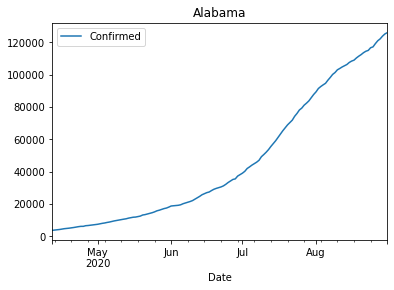

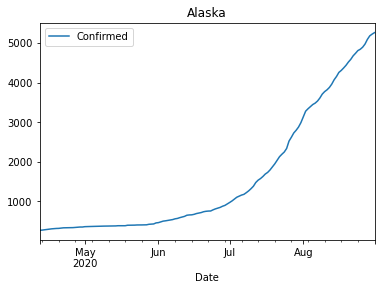

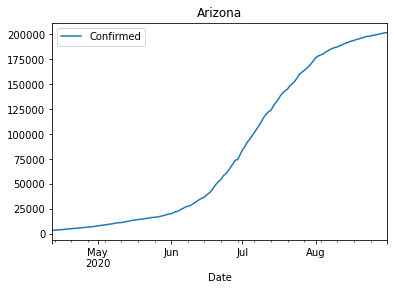

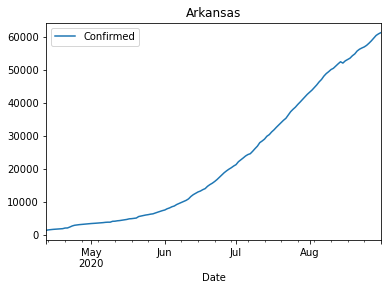

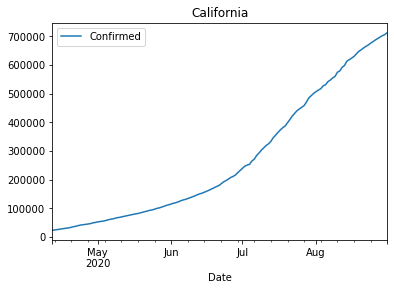

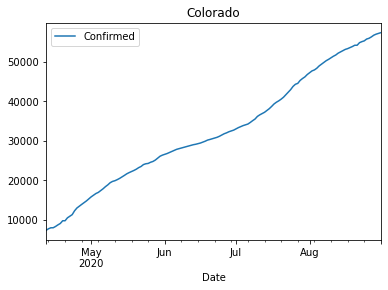

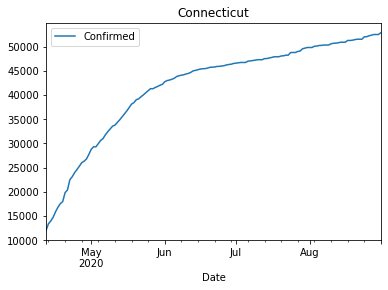

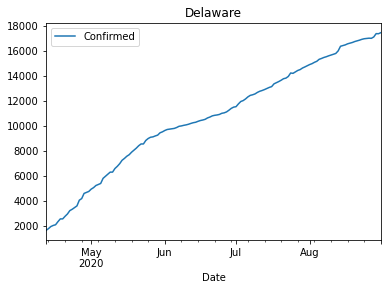

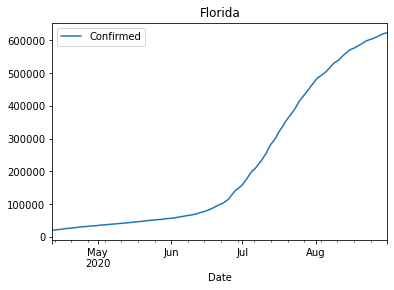

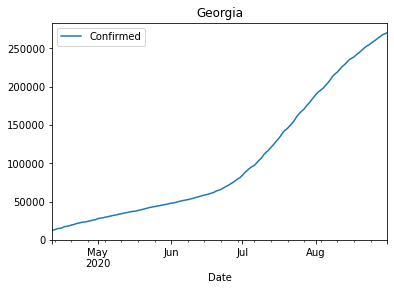

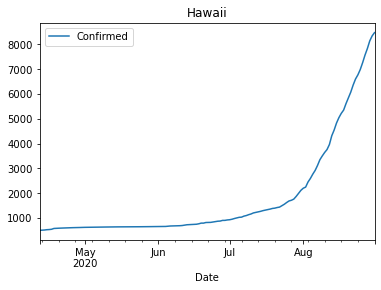

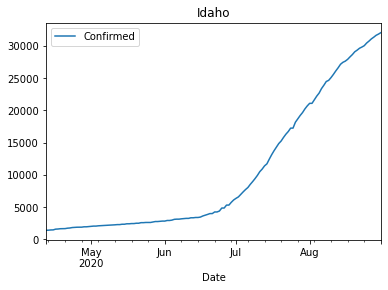

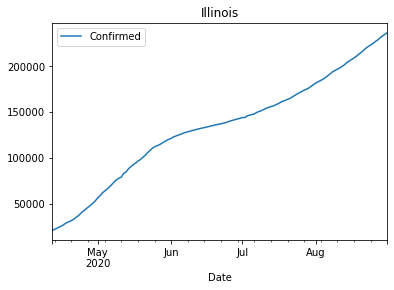

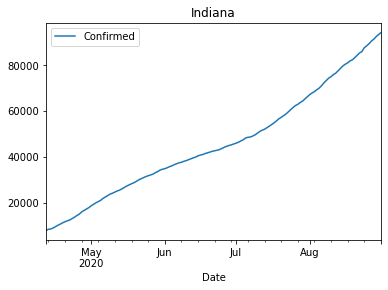

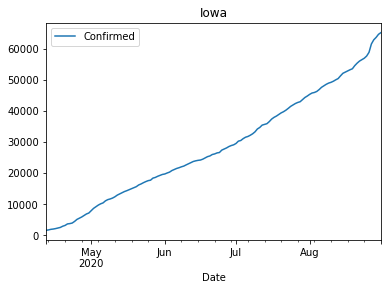

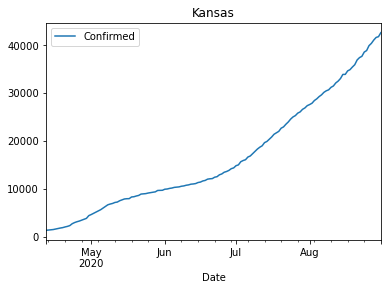

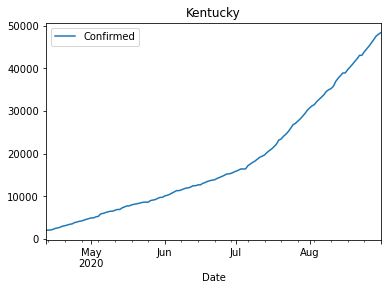

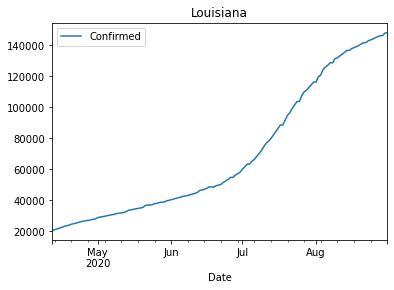

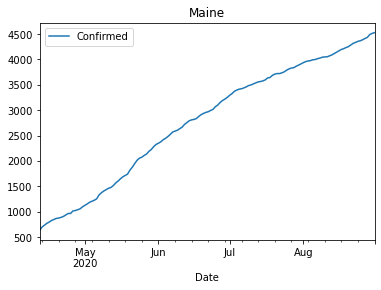

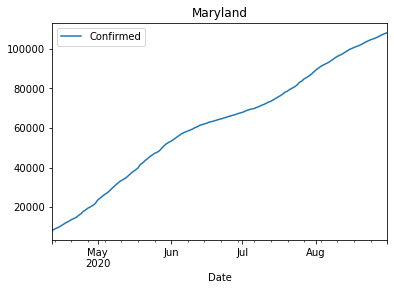

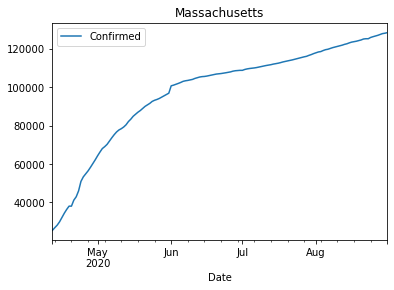

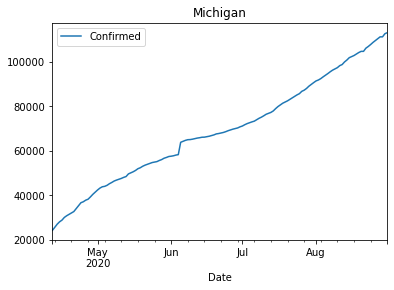

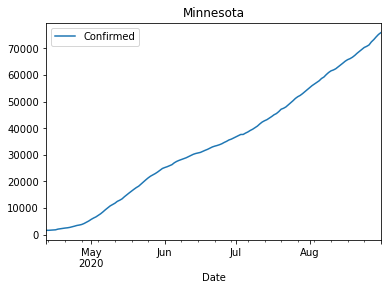

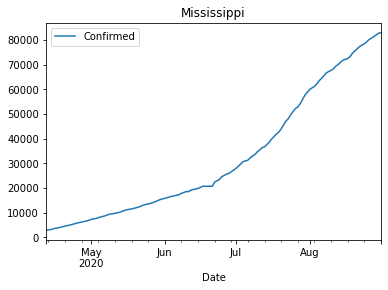

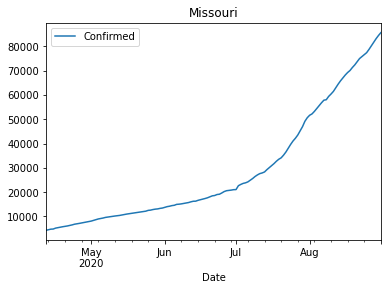

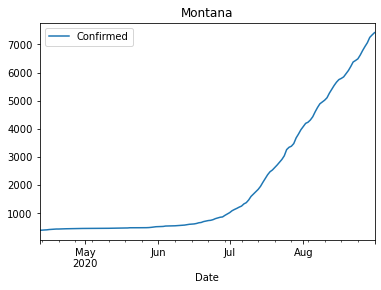

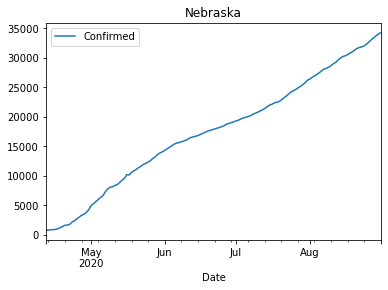

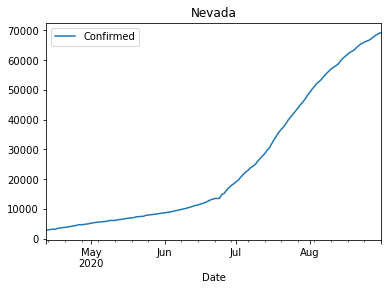

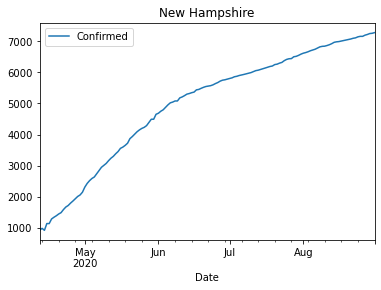

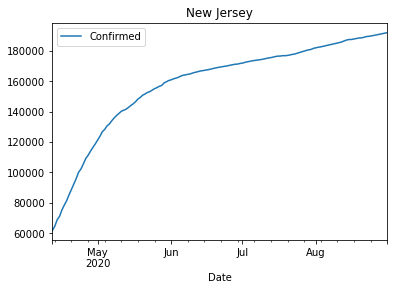

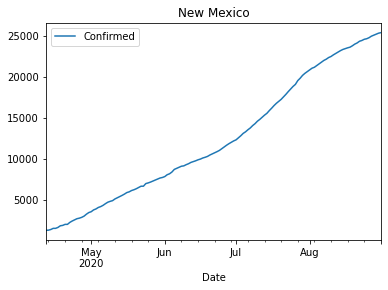

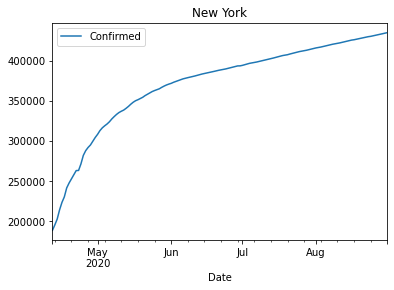

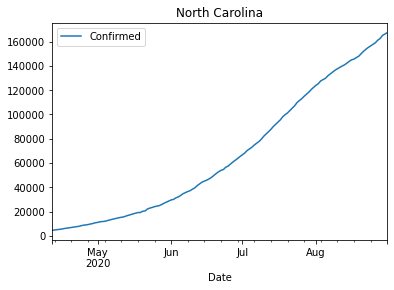

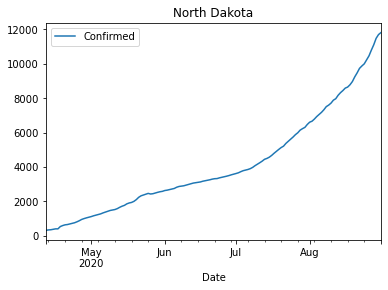

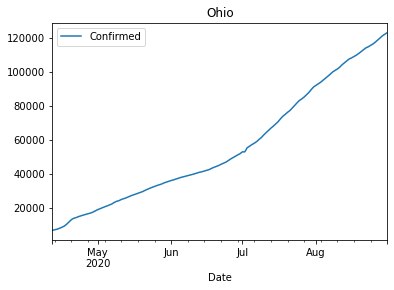

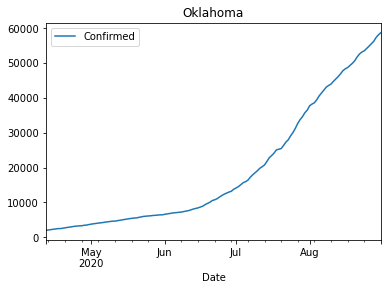

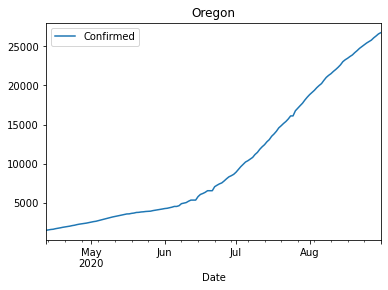

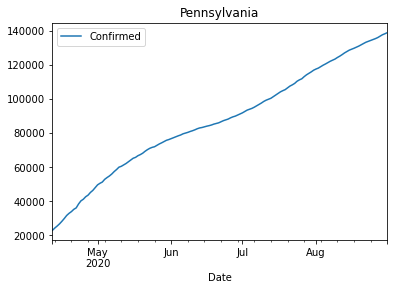

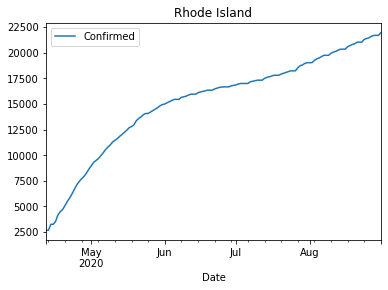

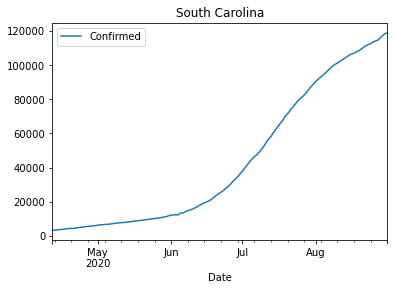

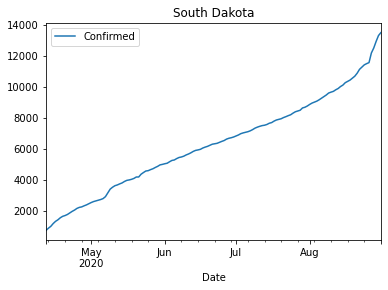

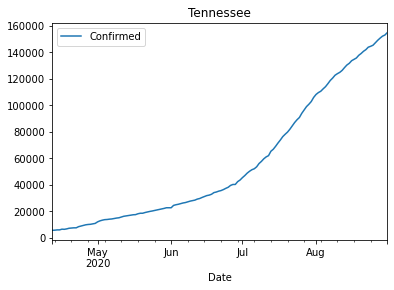

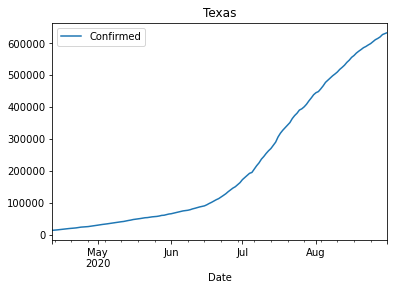

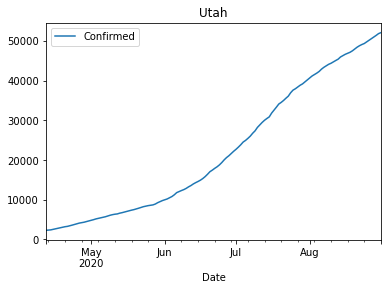

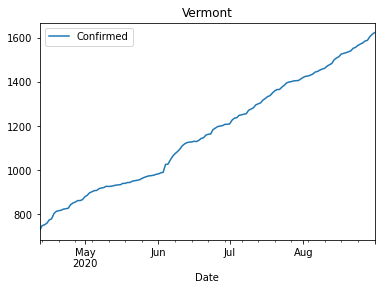

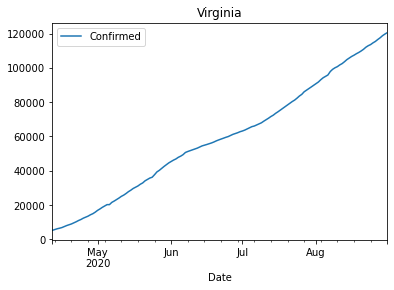

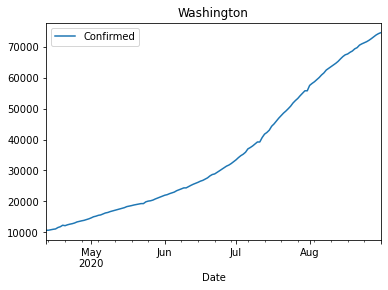

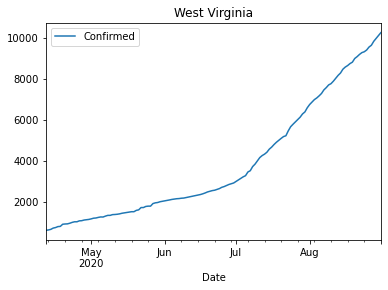

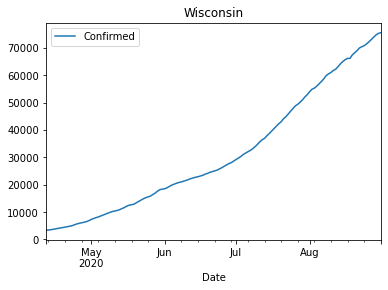

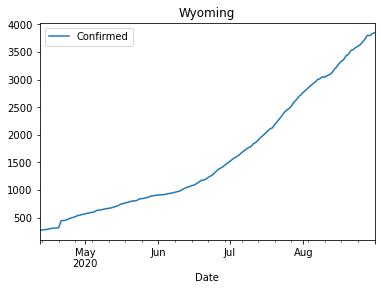

In [7]:
for state in state_names:
    state_df = confirmed_df[confirmed_df.Province_State == state][['Date', 'Confirmed']]
    state_df.plot('Date','Confirmed', title=state)
    pyplot.show()

### Fit Model

In [8]:
# Build model with best parameters
def build_best_confirmed_model(train_dates, test_dates, history, state, config, num_days):
    #t, d, s, p, b, r = config
    # t, d, b, r = config
    t, r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=False, seasonal=None, seasonal_periods=None)
    # fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    # Make predictions
    predictions = model_fit.forecast(num_days)
    # Plot
    ground_truth, = pyplot.plot(train_dates, history, label='ground truth')
    prediction_,  = pyplot.plot(test_dates, predictions, color='red', label='predictions')
    pyplot.legend(handles=[ground_truth, prediction_])
    pyplot.title(state)
    pyplot.ylabel('Confirmed')
    pyplot.xlabel('Month')
    pyplot.show()
    # Return predictions
    data = {
        'Province_State': state,
        'Date': test_dates,
        'Confirmed': predictions
    }
    dataframe = pd.DataFrame(data)
    return dataframe

# One-Step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    # t, d, s, p, b, r = config
    # t, d, b, r = config
    t, r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=False, seasonal=None, seasonal_periods=None)
    # model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=None, seasonal_periods=None)
    # fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# compute error
def measure_MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return array(data[:-n_test]), array(data[-n_test:])
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg, state):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_MAPE(test, predictions)
    return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, state, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg, state)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg, state)
        except:
            error = None
    return (cfg, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, state, parallel=True):
    print("State:", state)
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, state) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, state) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    print("\tTop 3 Scores For {}".format(state))
    for score in scores[:3]:
      print('\t--Score: {} {}'.format(score[1], score[0]))
    return scores
 
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    # t_params = ['add', 'mul']
    t_params = ['add']
    # d_params = [True, False]
    # s_params = ['add', None]
    # p_params = seasonal
    b_params = [True, False]
    r_params = [True]
    # create config instances
    for t in t_params:
      for b in b_params:
        for r in r_params:
          cfg = [t,r]
          models.append(cfg)
    return models

In [9]:
# Get all configs
cfgs = exp_smoothing_configs(seasonal=None)
cfgs

[['add', True], ['add', True]]

State: Alabama
	Top 3 Scores For Alabama
	--Score: 0.3519971831388438 ['add', True]
	--Score: 0.3519971831388438 ['add', True]


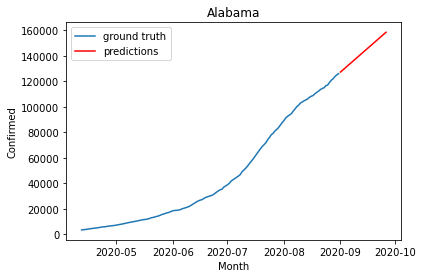

State: Alaska
	Top 3 Scores For Alaska
	--Score: 0.4426037595033641 ['add', True]
	--Score: 0.4426037595033641 ['add', True]


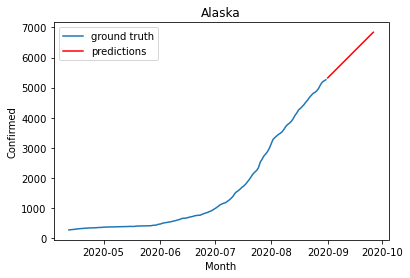

State: Arizona
	Top 3 Scores For Arizona
	--Score: 0.12919259817618037 ['add', True]
	--Score: 0.12919259817618037 ['add', True]


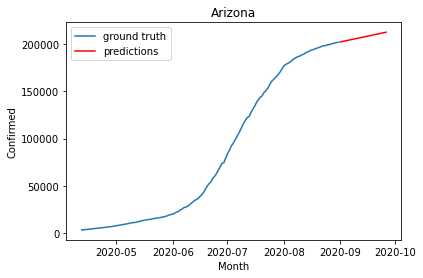

State: Arkansas
	Top 3 Scores For Arkansas
	--Score: 0.36120982541606755 ['add', True]
	--Score: 0.36120982541606755 ['add', True]


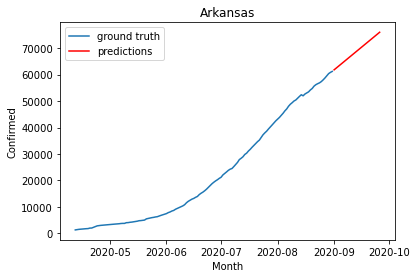

State: California
	Top 3 Scores For California
	--Score: 0.3459731982816195 ['add', True]
	--Score: 0.3459731982816195 ['add', True]


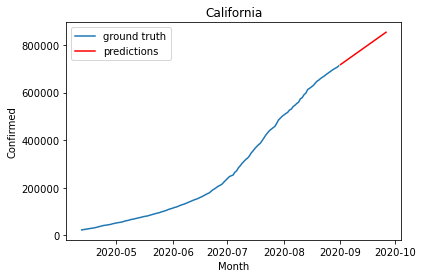

State: Colorado
	Top 3 Scores For Colorado
	--Score: 0.21651940579310142 ['add', True]
	--Score: 0.21651940579310142 ['add', True]


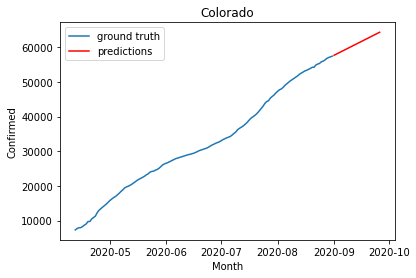

State: Connecticut
	Top 3 Scores For Connecticut
	--Score: 0.18427808809586463 ['add', True]
	--Score: 0.18427808809586463 ['add', True]


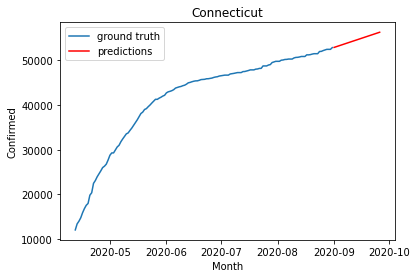

State: Delaware
	Top 3 Scores For Delaware
	--Score: 0.41486146516651534 ['add', True]
	--Score: 0.41486146516651534 ['add', True]


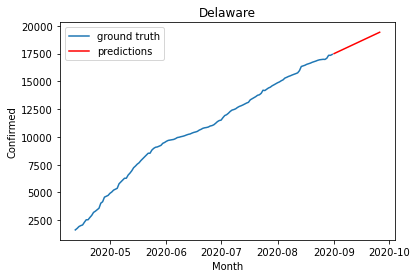

State: Florida
	Top 3 Scores For Florida
	--Score: 0.1476271648072619 ['add', True]
	--Score: 0.1476271648072619 ['add', True]


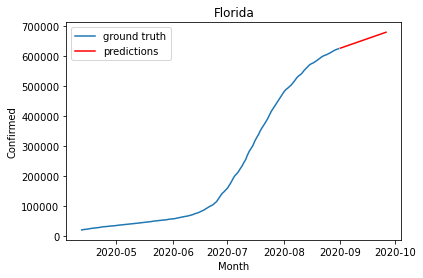

State: Georgia
	Top 3 Scores For Georgia
	--Score: 0.16689461571569703 ['add', True]
	--Score: 0.16689461571569703 ['add', True]


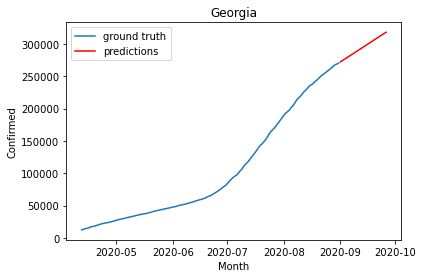

State: Hawaii
	Top 3 Scores For Hawaii
	--Score: 0.9987197028305346 ['add', True]
	--Score: 0.9987197028305346 ['add', True]


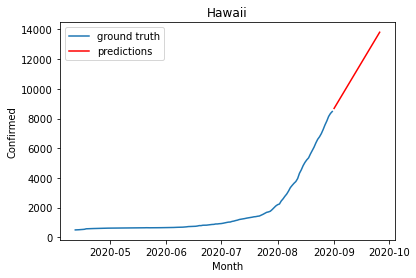

State: Idaho
	Top 3 Scores For Idaho
	--Score: 0.32614650283875324 ['add', True]
	--Score: 0.32614650283875324 ['add', True]


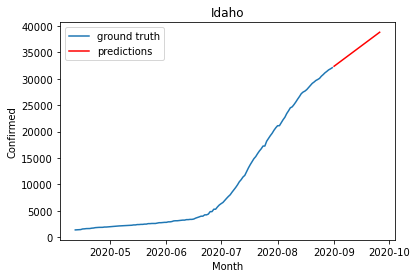

State: Illinois
	Top 3 Scores For Illinois
	--Score: 0.12063323625209695 ['add', True]
	--Score: 0.12063323625209695 ['add', True]


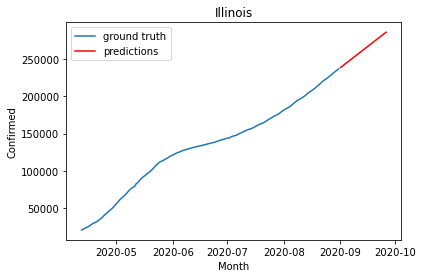

State: Indiana
	Top 3 Scores For Indiana
	--Score: 0.25714949573626283 ['add', True]
	--Score: 0.25714949573626283 ['add', True]


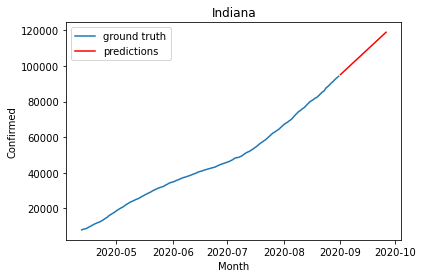

State: Iowa
	Top 3 Scores For Iowa
	--Score: 0.620704875108716 ['add', True]
	--Score: 0.620704875108716 ['add', True]


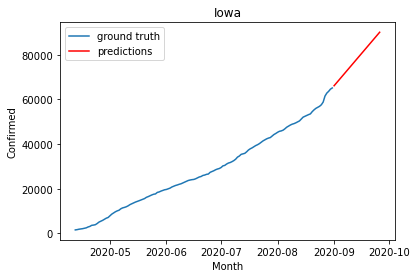

State: Kansas
	Top 3 Scores For Kansas
	--Score: 0.551341875189178 ['add', True]
	--Score: 0.551341875189178 ['add', True]


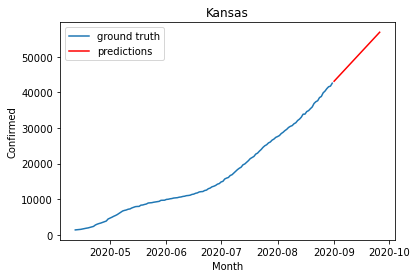

State: Kentucky
	Top 3 Scores For Kentucky
	--Score: 0.49691788418012045 ['add', True]
	--Score: 0.49691788418012045 ['add', True]


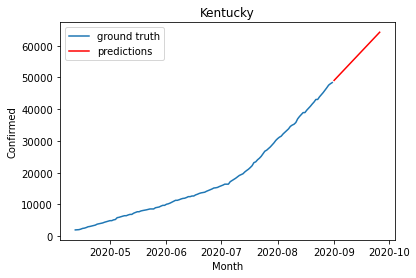

State: Louisiana
	Top 3 Scores For Louisiana
	--Score: 0.23127125670153156 ['add', True]
	--Score: 0.23127125670153156 ['add', True]


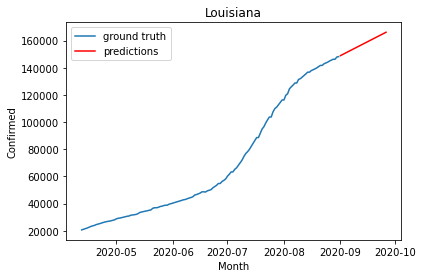

State: Maine
	Top 3 Scores For Maine
	--Score: 0.19761874506700744 ['add', True]
	--Score: 0.19761874506700744 ['add', True]


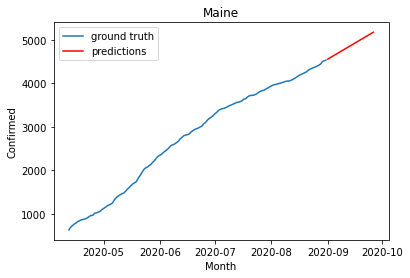

State: Maryland
	Top 3 Scores For Maryland
	--Score: 0.09889000894927953 ['add', True]
	--Score: 0.09889000894927953 ['add', True]


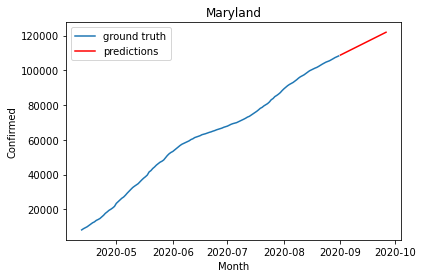

State: Massachusetts
	Top 3 Scores For Massachusetts
	--Score: 0.09926310121548268 ['add', True]
	--Score: 0.09926310121548268 ['add', True]


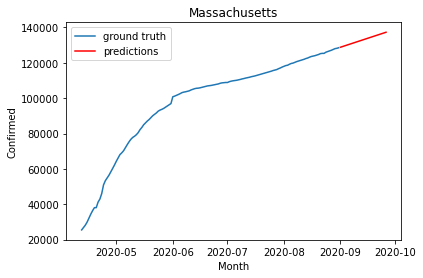

State: Michigan
	Top 3 Scores For Michigan
	--Score: 0.2793642184204408 ['add', True]
	--Score: 0.2793642184204408 ['add', True]


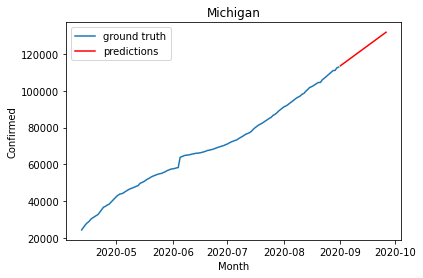

State: Minnesota
	Top 3 Scores For Minnesota
	--Score: 0.20823152273284534 ['add', True]
	--Score: 0.20823152273284534 ['add', True]


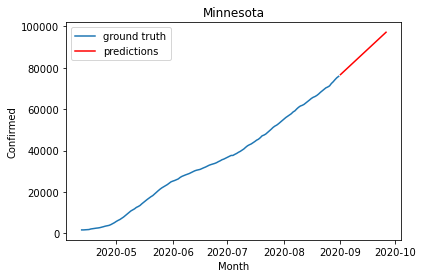

State: Mississippi
	Top 3 Scores For Mississippi
	--Score: 0.2863633508530596 ['add', True]
	--Score: 0.2863633508530596 ['add', True]


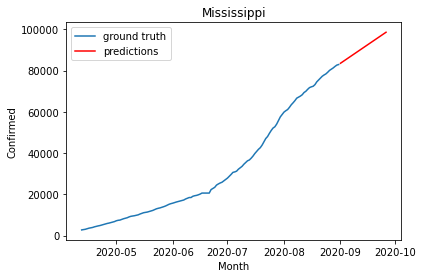

State: Missouri
	Top 3 Scores For Missouri
	--Score: 0.31306591715487797 ['add', True]
	--Score: 0.31306591715487797 ['add', True]


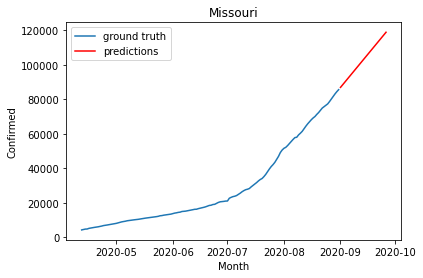

State: Montana
	Top 3 Scores For Montana
	--Score: 0.6405447859781406 ['add', True]
	--Score: 0.6405447859781406 ['add', True]


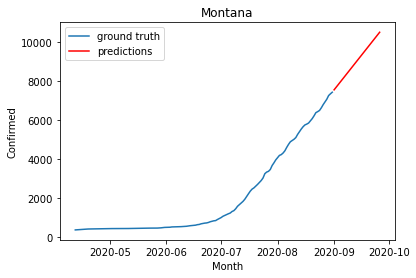

State: Nebraska
	Top 3 Scores For Nebraska
	--Score: 0.2336296158694617 ['add', True]
	--Score: 0.2336296158694617 ['add', True]


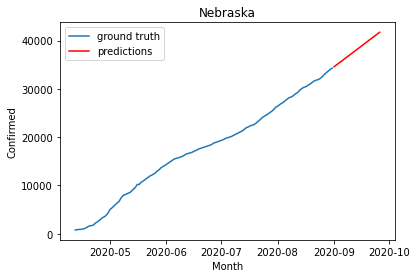

State: Nevada
	Top 3 Scores For Nevada
	--Score: 0.2695532263693556 ['add', True]
	--Score: 0.2695532263693556 ['add', True]


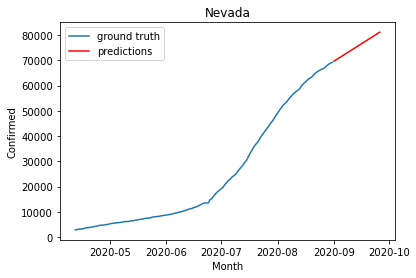

State: New Hampshire
	Top 3 Scores For New Hampshire
	--Score: 0.13189233612494788 ['add', True]
	--Score: 0.13189233612494788 ['add', True]


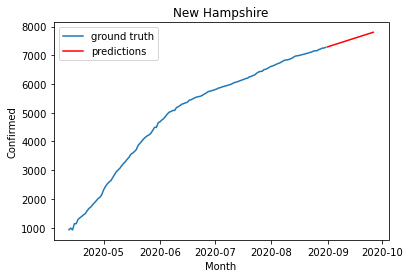

State: New Jersey
	Top 3 Scores For New Jersey
	--Score: 0.07968877603360108 ['add', True]
	--Score: 0.07968877603360108 ['add', True]


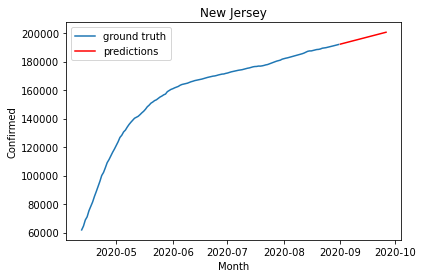

State: New Mexico
	Top 3 Scores For New Mexico
	--Score: 0.16208423543160813 ['add', True]
	--Score: 0.16208423543160813 ['add', True]


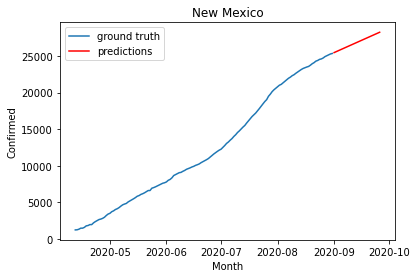

State: New York
	Top 3 Scores For New York
	--Score: 0.03885463039262451 ['add', True]
	--Score: 0.03885463039262451 ['add', True]


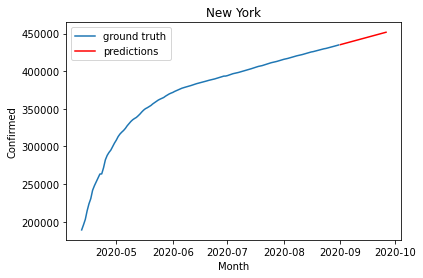

State: North Carolina
	Top 3 Scores For North Carolina
	--Score: 0.24743814916936943 ['add', True]
	--Score: 0.24743814916936943 ['add', True]


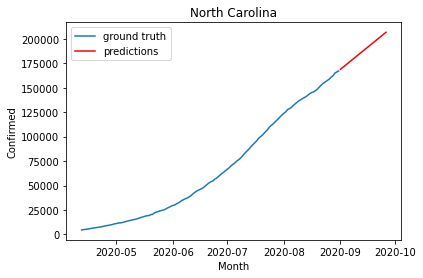

State: North Dakota
	Top 3 Scores For North Dakota
	--Score: 0.6958847017098159 ['add', True]
	--Score: 0.6958847017098159 ['add', True]


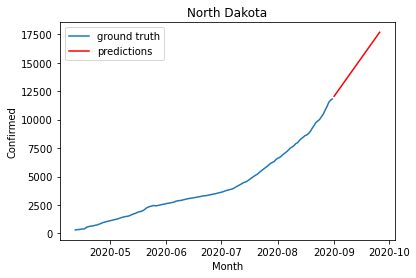

State: Ohio
	Top 3 Scores For Ohio
	--Score: 0.15512679264298135 ['add', True]
	--Score: 0.15512679264298135 ['add', True]


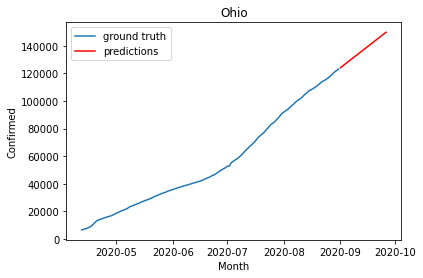

State: Oklahoma
	Top 3 Scores For Oklahoma
	--Score: 0.28039454631009647 ['add', True]
	--Score: 0.28039454631009647 ['add', True]


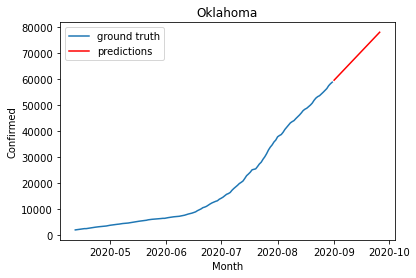

State: Oregon
	Top 3 Scores For Oregon
	--Score: 0.2257347494404582 ['add', True]
	--Score: 0.2257347494404582 ['add', True]


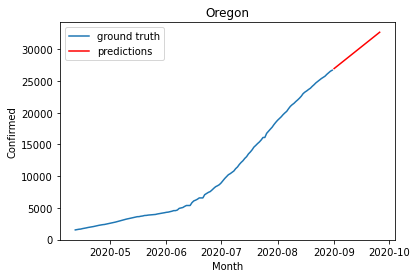

State: Pennsylvania
	Top 3 Scores For Pennsylvania
	--Score: 0.08512191380505282 ['add', True]
	--Score: 0.08512191380505282 ['add', True]


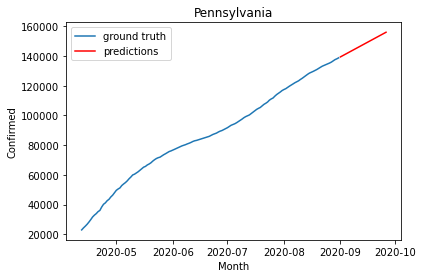

State: Rhode Island
	Top 3 Scores For Rhode Island
	--Score: 0.32604411215050216 ['add', True]
	--Score: 0.32604411215050216 ['add', True]


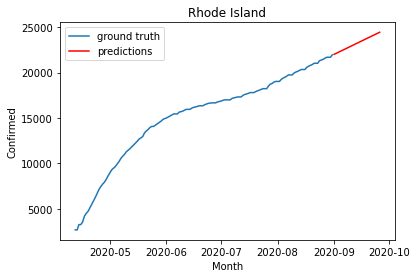

State: South Carolina
	Top 3 Scores For South Carolina
	--Score: 0.1911986426197948 ['add', True]
	--Score: 0.1911986426197948 ['add', True]


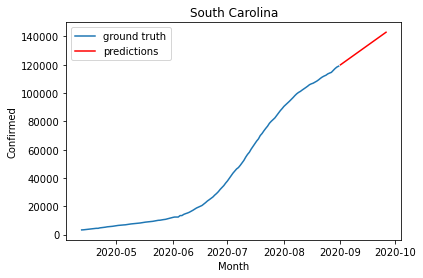

State: South Dakota
	Top 3 Scores For South Dakota
	--Score: 0.687692231209482 ['add', True]
	--Score: 0.687692231209482 ['add', True]


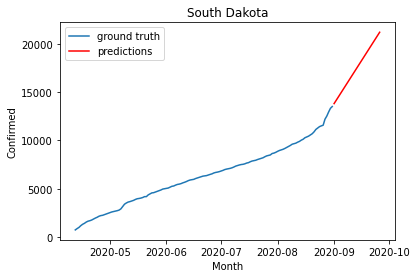

State: Tennessee
	Top 3 Scores For Tennessee
	--Score: 0.302159911307195 ['add', True]
	--Score: 0.302159911307195 ['add', True]


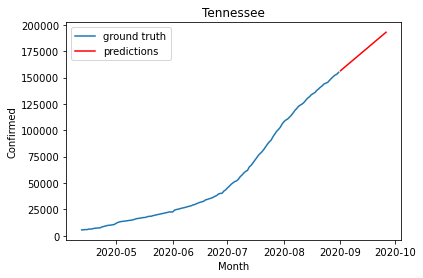

State: Texas
	Top 3 Scores For Texas
	--Score: 0.2332293819192339 ['add', True]
	--Score: 0.2332293819192339 ['add', True]


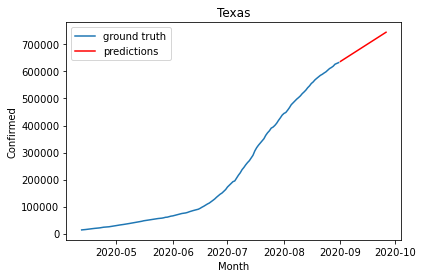

State: Utah
	Top 3 Scores For Utah
	--Score: 0.1614111532758817 ['add', True]
	--Score: 0.1614111532758817 ['add', True]


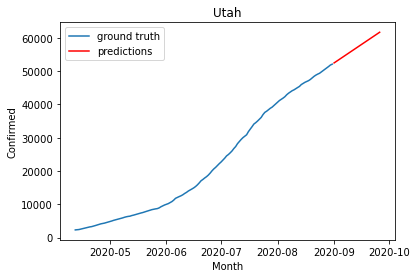

State: Vermont
	Top 3 Scores For Vermont
	--Score: 0.2215959026774953 ['add', True]
	--Score: 0.2215959026774953 ['add', True]


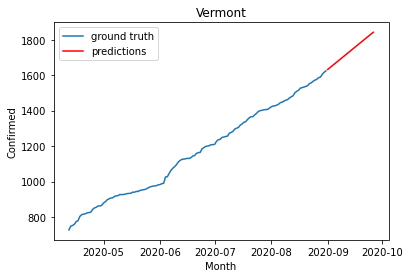

State: Virginia
	Top 3 Scores For Virginia
	--Score: 0.14621091543616155 ['add', True]
	--Score: 0.14621091543616155 ['add', True]


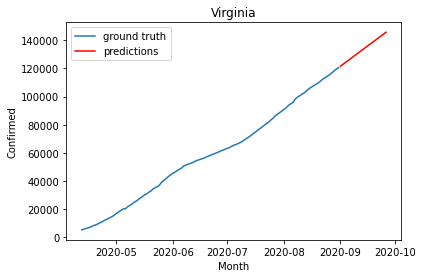

State: Washington
	Top 3 Scores For Washington
	--Score: 0.2393958451240602 ['add', True]
	--Score: 0.2393958451240602 ['add', True]


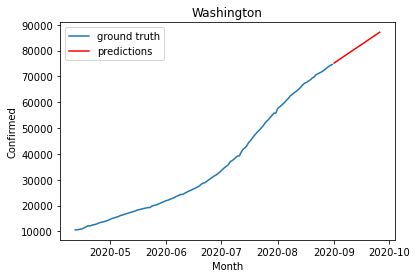

State: West Virginia
	Top 3 Scores For West Virginia
	--Score: 0.3960735954563946 ['add', True]
	--Score: 0.3960735954563946 ['add', True]


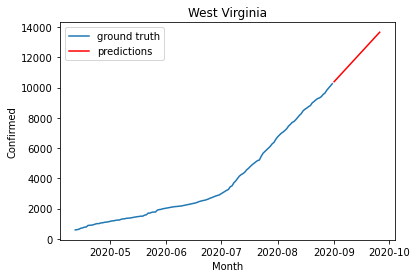

State: Wisconsin
	Top 3 Scores For Wisconsin
	--Score: 0.36811067767759476 ['add', True]
	--Score: 0.36811067767759476 ['add', True]


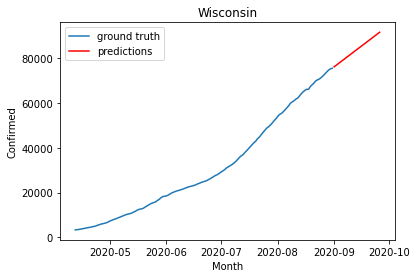

State: Wyoming
	Top 3 Scores For Wyoming
	--Score: 0.549272239486409 ['add', True]
	--Score: 0.549272239486409 ['add', True]


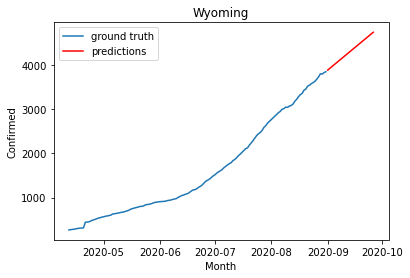

In [10]:
# Get train and test dates for plot
train_dates = sorted(list(confirmed_df.Date.unique()))
test_dates  = sorted(list(test_df.Date.unique()))

# Average overall MAPE
overall_average_MAPE = 0

# Setup dataframe to store results
confirmed_output_df = pd.DataFrame()

# Grid search for each state
for state in state_names:
  scores = grid_search(confirmed_df[confirmed_df.Province_State == state].Confirmed, cfgs, 20, state, parallel=True)
  overall_average_MAPE += scores[0][1]
  predictions = build_best_confirmed_model(train_dates, test_dates, confirmed_df[confirmed_df.Province_State == state].Confirmed, state, scores[0][0], len(test_dates))
  confirmed_output_df = confirmed_output_df.append(predictions)

In [11]:
confirmed_output_df

,Province_State,Date,Confirmed
0,Alabama,2020-09-01,127360.409428
1,Alabama,2020-09-02,128609.985519
2,Alabama,2020-09-03,129859.561610
3,Alabama,2020-09-04,131109.137700
4,Alabama,2020-09-05,132358.713791
...,...,...,...
21,Wyoming,2020-09-22,4605.262754
22,Wyoming,2020-09-23,4639.486396
23,Wyoming,2020-09-24,4673.710038
24,Wyoming,2020-09-25,4707.933680


In [12]:
# Average MAPE across validation dataset
overall_average_MAPE = overall_average_MAPE/50
print("Average MAPE for Confirmed: {}%".format(overall_average_MAPE))

confirmed_output_df = confirmed_output_df.sort_values(by=['Date', 'Province_State'])
confirmed_output_df.to_csv('Round_1/ETS_Confirmed_Predictions.csv', index=False)

Average MAPE for Confirmed: 0.2983036412988484%


# Deaths Dataset Modeling

### Make Plots For Each State

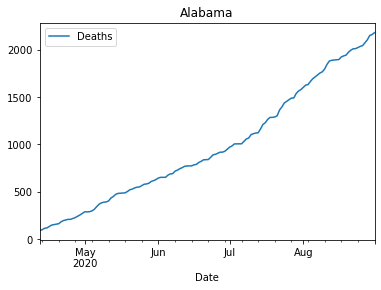

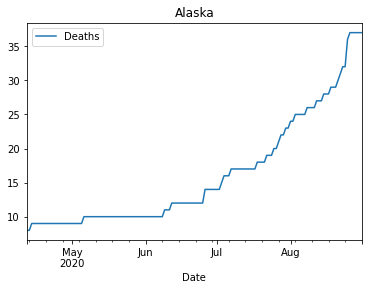

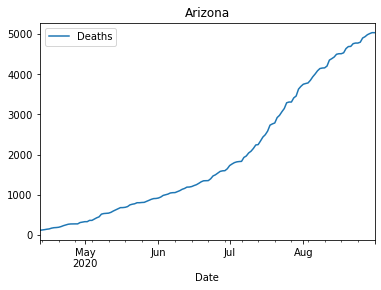

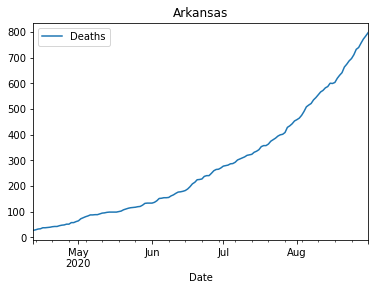

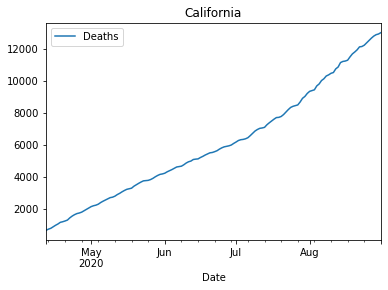

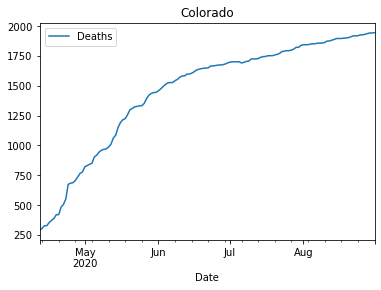

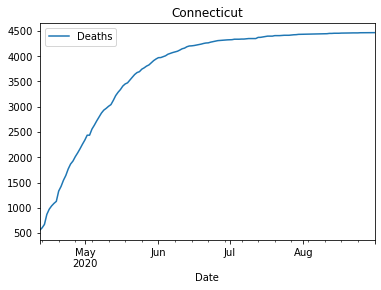

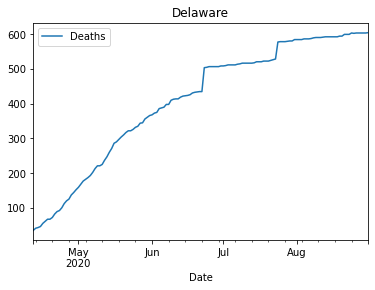

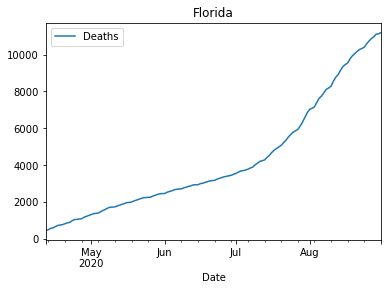

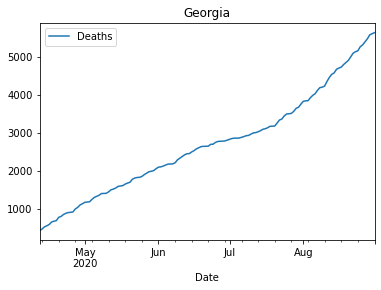

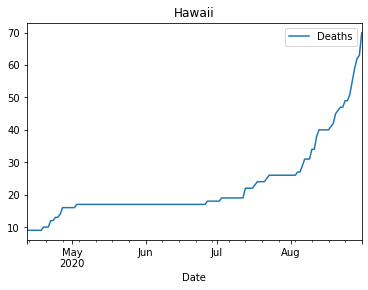

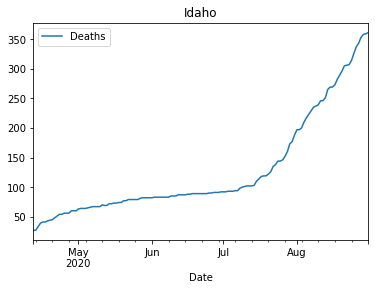

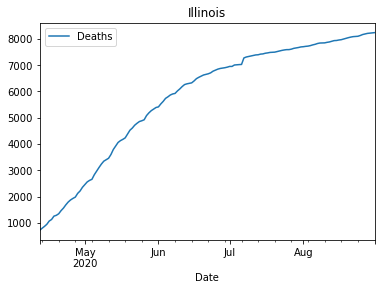

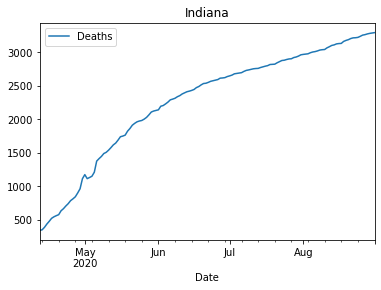

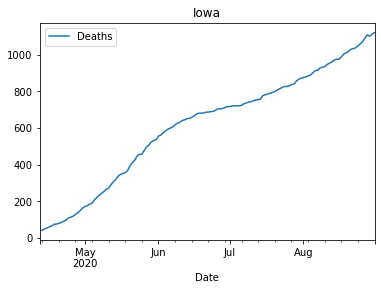

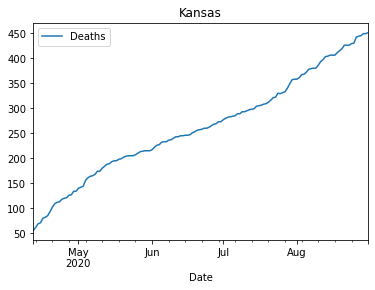

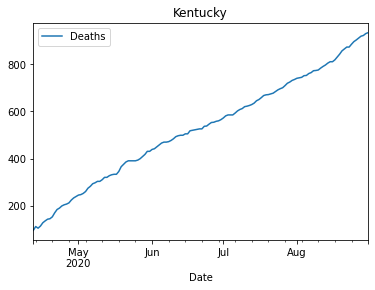

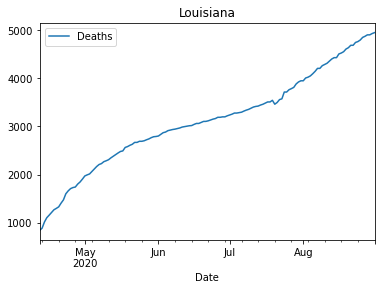

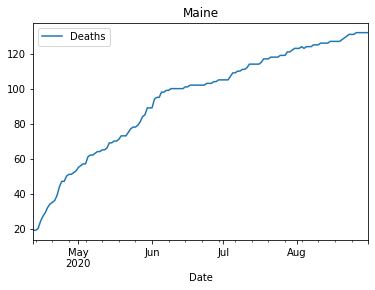

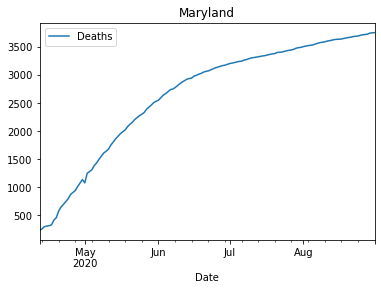

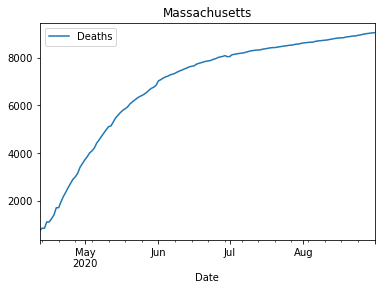

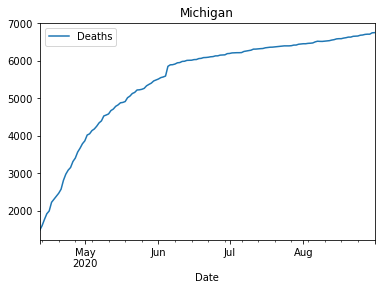

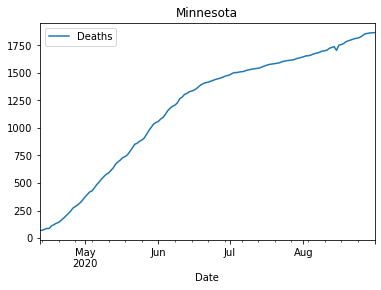

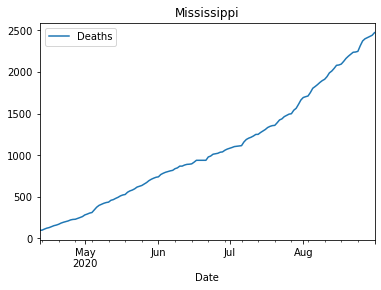

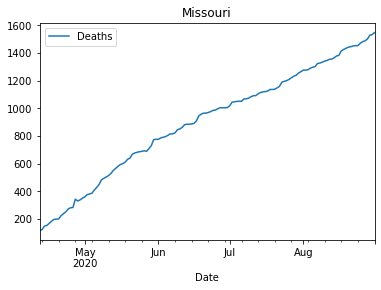

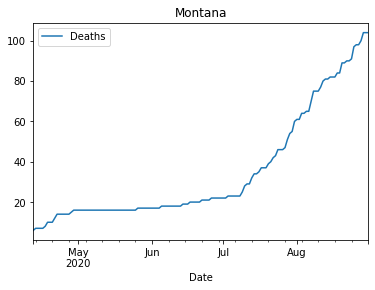

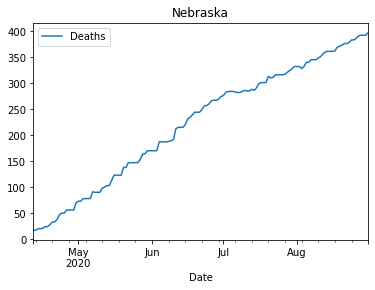

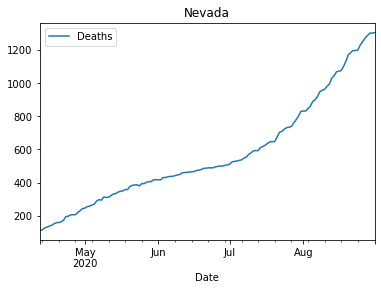

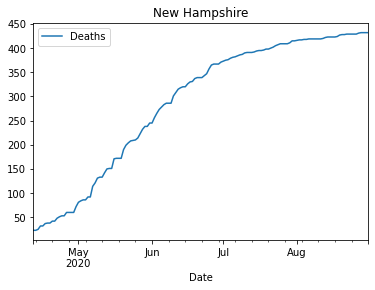

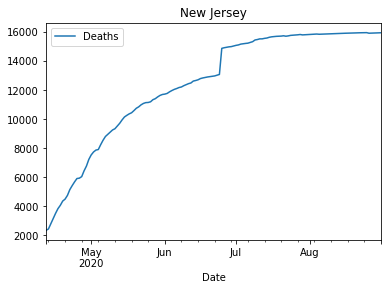

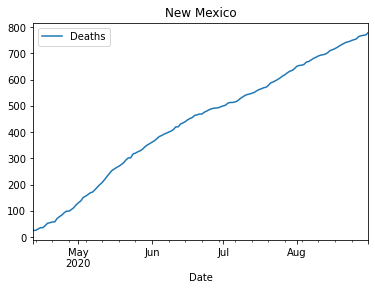

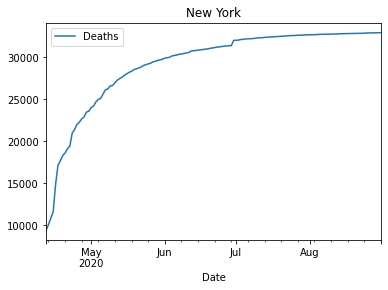

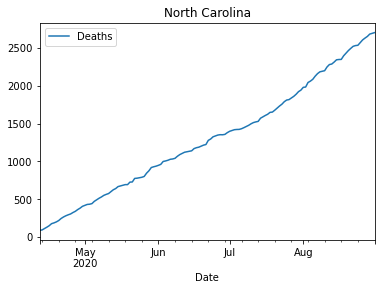

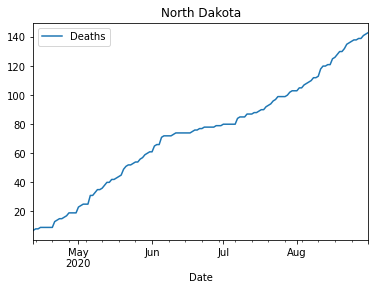

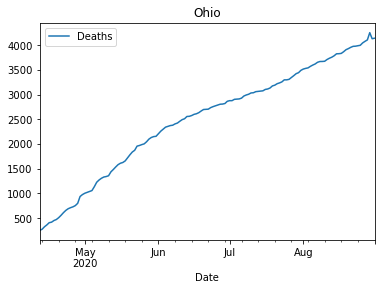

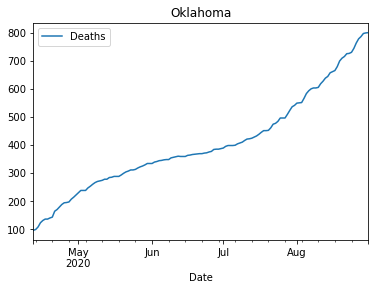

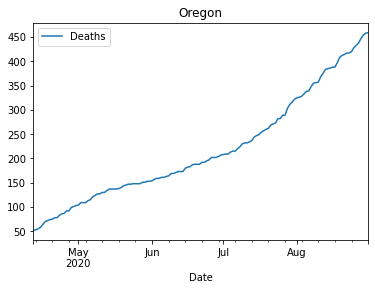

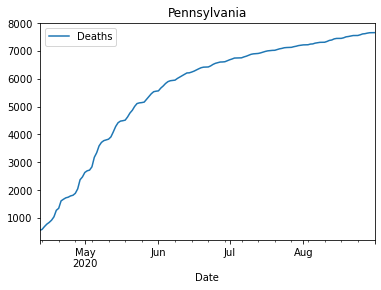

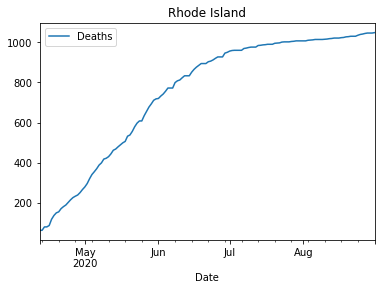

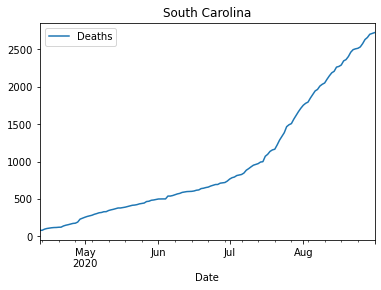

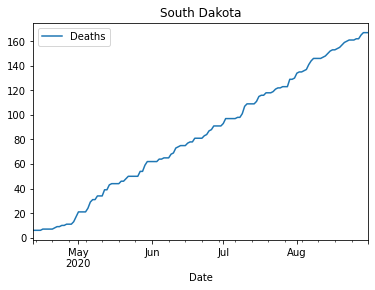

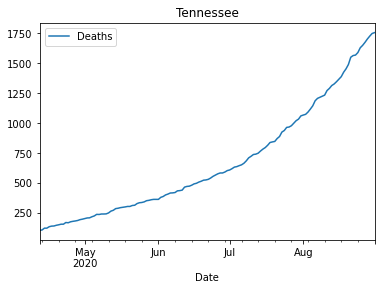

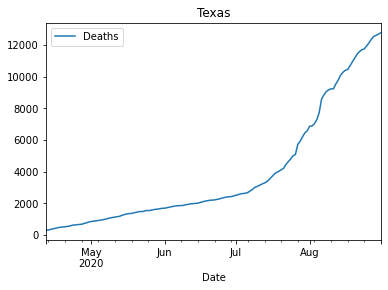

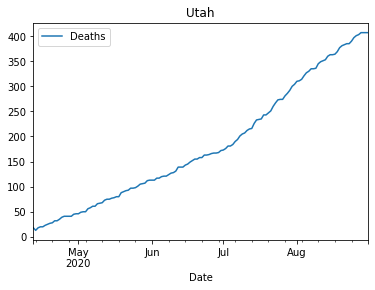

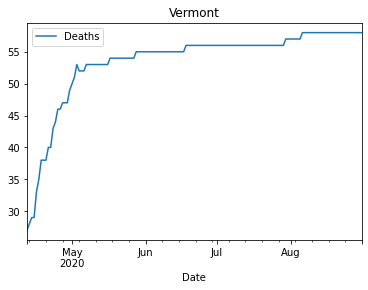

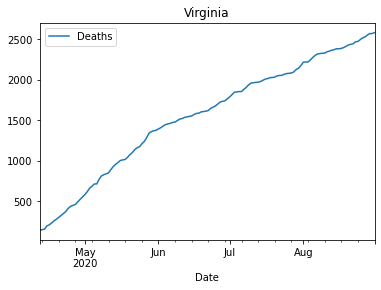

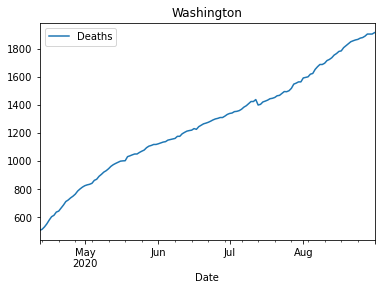

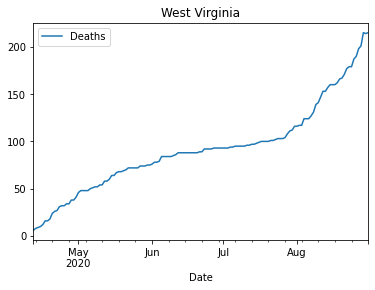

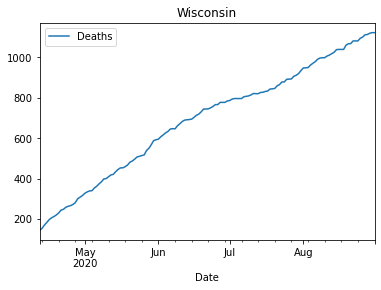

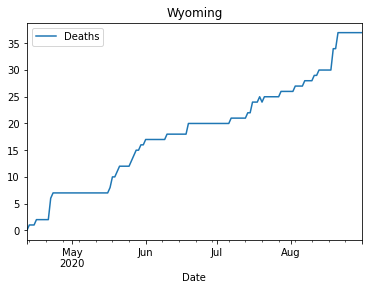

In [13]:
for state in state_names:
    state_df = deaths_df[deaths_df.Province_State == state][['Date', 'Deaths']]
    state_df.plot('Date','Deaths', title=state)
    pyplot.show()

### Fit Model

In [14]:
# Build model with best parameters
def build_best_deaths_model(train_dates, test_dates, history, state, config, num_days):
    # t, d, s, p, b, r = config
    t, r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=False, seasonal=None, seasonal_periods=None)
    # fit model
    model_fit = model.fit(optimized=True, remove_bias=r)
    # Make predictions
    predictions = model_fit.forecast(num_days)
    # Plot
    ground_truth, = pyplot.plot(train_dates, history, label='ground truth')
    prediction_,  = pyplot.plot(test_dates, predictions, color='red', label='predictions')
    pyplot.legend(handles=[ground_truth, prediction_])
    pyplot.title(state)
    pyplot.ylabel('Deaths')
    pyplot.xlabel('Month')
    pyplot.show()
    # Return predictions
    data = {
        'Province_State': state,
        'Date': test_dates,
        'Deaths': predictions
    }
    dataframe = pd.DataFrame(data)
    return dataframe

State: Alabama
	Top 3 Scores For Alabama
	--Score: 0.6064162495973044 ['add', True]
	--Score: 0.6064162495973044 ['add', True]


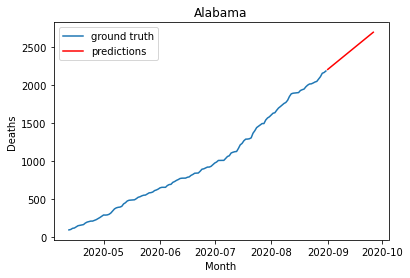

State: Alaska
	Top 3 Scores For Alaska
	--Score: 2.2390994751311593 ['add', True]
	--Score: 2.2390994751311593 ['add', True]


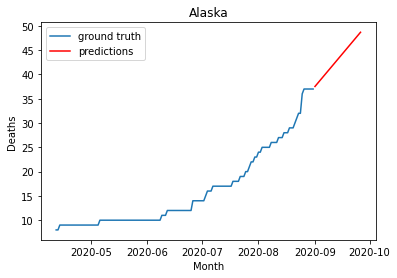

State: Arizona
	Top 3 Scores For Arizona
	--Score: 0.7438724018302573 ['add', True]
	--Score: 0.7438724018302573 ['add', True]


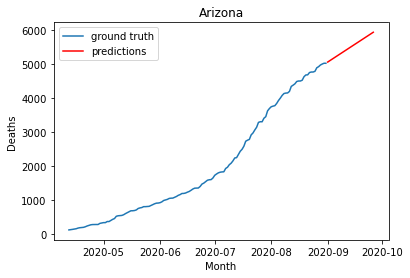

State: Arkansas
	Top 3 Scores For Arkansas
	--Score: 0.6549974437519568 ['add', True]
	--Score: 0.6549974437519568 ['add', True]


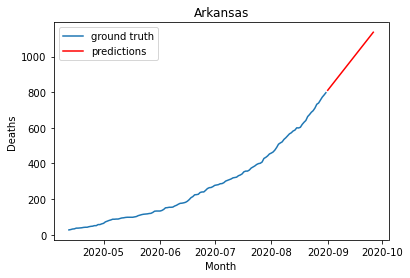

State: California
	Top 3 Scores For California
	--Score: 0.48905488114670176 ['add', True]
	--Score: 0.48905488114670176 ['add', True]


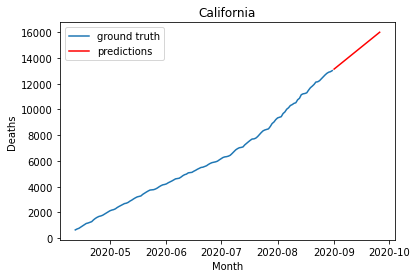

State: Colorado
	Top 3 Scores For Colorado
	--Score: 0.14732844016718505 ['add', True]
	--Score: 0.14732844016718505 ['add', True]


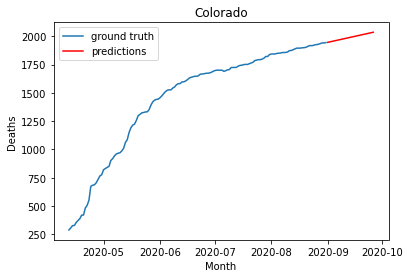

State: Connecticut
	Top 3 Scores For Connecticut
	--Score: 0.0834437965847598 ['add', True]
	--Score: 0.0834437965847598 ['add', True]


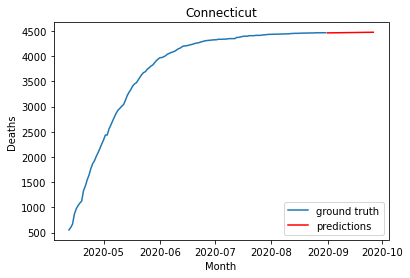

State: Delaware
	Top 3 Scores For Delaware
	--Score: 0.2227564623404633 ['add', True]
	--Score: 0.2227564623404633 ['add', True]


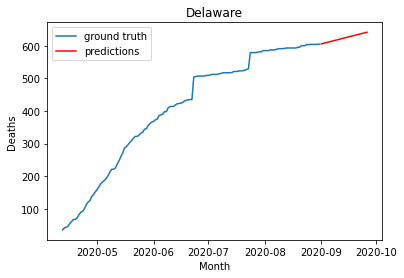

State: Florida
	Top 3 Scores For Florida
	--Score: 0.49467592745032596 ['add', True]
	--Score: 0.49467592745032596 ['add', True]


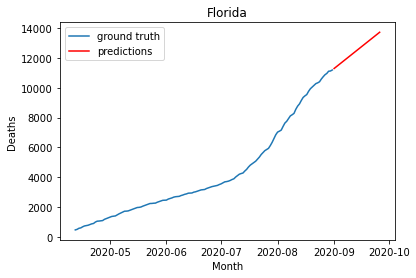

State: Georgia
	Top 3 Scores For Georgia
	--Score: 0.5678980908210122 ['add', True]
	--Score: 0.5678980908210122 ['add', True]


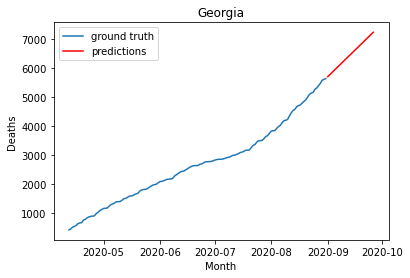

State: Hawaii
	Top 3 Scores For Hawaii
	--Score: 3.050519997093655 ['add', True]
	--Score: 3.050519997093655 ['add', True]


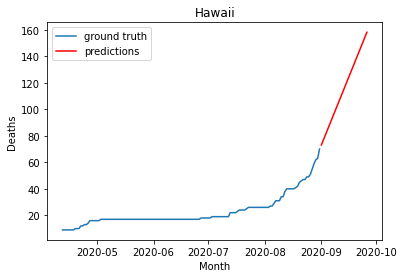

State: Idaho
	Top 3 Scores For Idaho
	--Score: 1.2500197757532712 ['add', True]
	--Score: 1.2500197757532712 ['add', True]


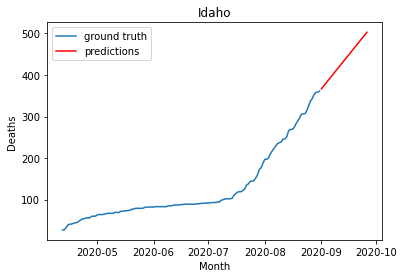

State: Illinois
	Top 3 Scores For Illinois
	--Score: 0.10789227007445197 ['add', True]
	--Score: 0.10789227007445197 ['add', True]


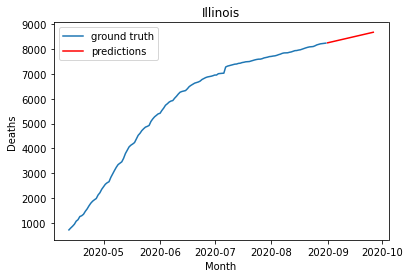

State: Indiana
	Top 3 Scores For Indiana
	--Score: 0.1795958916299997 ['add', True]
	--Score: 0.1795958916299997 ['add', True]


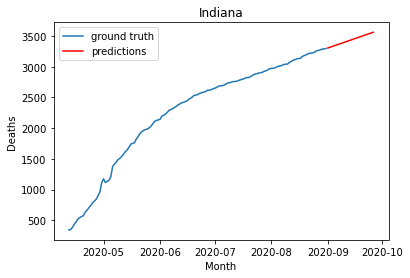

State: Iowa
	Top 3 Scores For Iowa
	--Score: 0.46750203109909483 ['add', True]
	--Score: 0.46750203109909483 ['add', True]


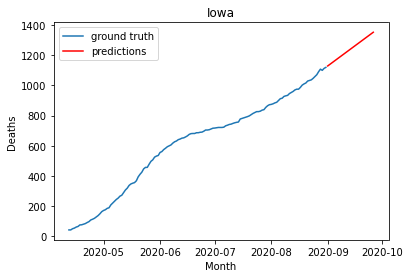

State: Kansas
	Top 3 Scores For Kansas
	--Score: 0.575760420452052 ['add', True]
	--Score: 0.575760420452052 ['add', True]


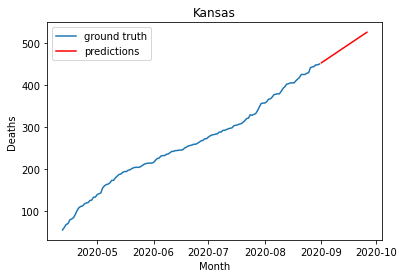

State: Kentucky
	Top 3 Scores For Kentucky
	--Score: 0.41564446895222 ['add', True]
	--Score: 0.41564446895222 ['add', True]


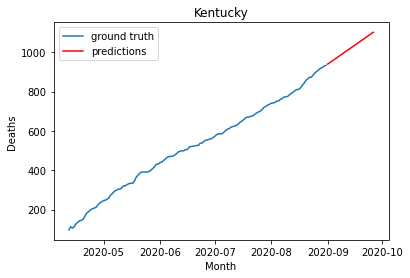

State: Louisiana
	Top 3 Scores For Louisiana
	--Score: 0.34774824807219673 ['add', True]
	--Score: 0.34774824807219673 ['add', True]


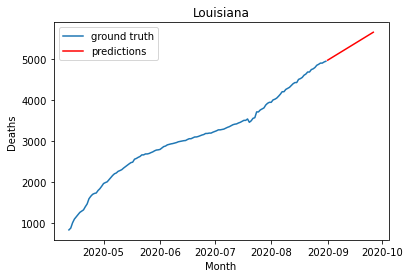

State: Maine
	Top 3 Scores For Maine
	--Score: 0.3282590573538697 ['add', True]
	--Score: 0.3282590573538697 ['add', True]


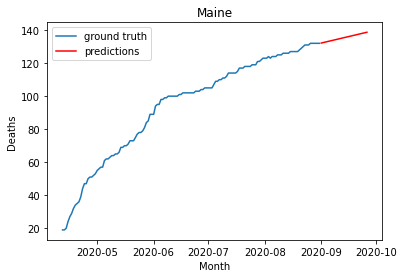

State: Maryland
	Top 3 Scores For Maryland
	--Score: 0.09485160298127804 ['add', True]
	--Score: 0.09485160298127804 ['add', True]


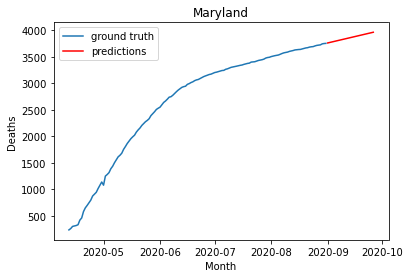

State: Massachusetts
	Top 3 Scores For Massachusetts
	--Score: 0.09032191942919585 ['add', True]
	--Score: 0.09032191942919585 ['add', True]


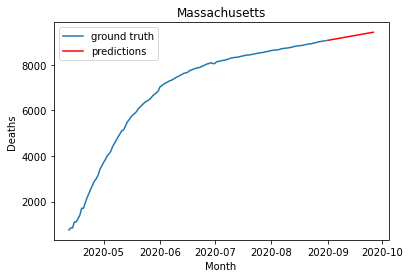

State: Michigan
	Top 3 Scores For Michigan
	--Score: 0.13134488399356817 ['add', True]
	--Score: 0.13134488399356817 ['add', True]


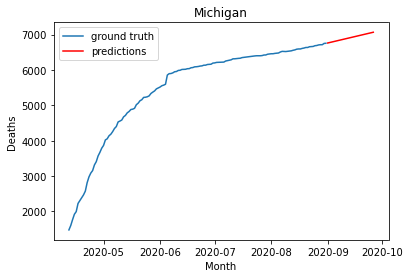

State: Minnesota
	Top 3 Scores For Minnesota
	--Score: 0.47270127188701555 ['add', True]
	--Score: 0.47270127188701555 ['add', True]


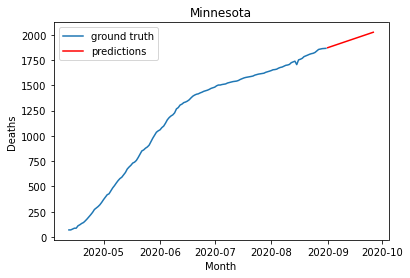

State: Mississippi
	Top 3 Scores For Mississippi
	--Score: 0.6142165997493386 ['add', True]
	--Score: 0.6142165997493386 ['add', True]


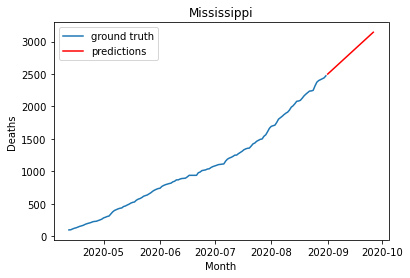

State: Missouri
	Top 3 Scores For Missouri
	--Score: 0.386823637487979 ['add', True]
	--Score: 0.386823637487979 ['add', True]


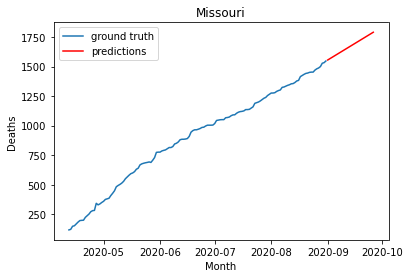

State: Montana
	Top 3 Scores For Montana
	--Score: 1.697022424306509 ['add', True]
	--Score: 1.697022424306509 ['add', True]


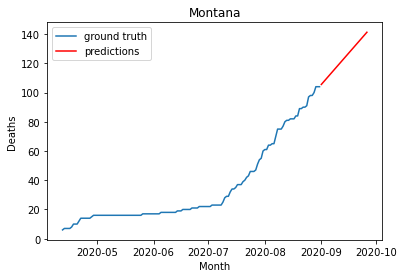

State: Nebraska
	Top 3 Scores For Nebraska
	--Score: 0.5191838863818588 ['add', True]
	--Score: 0.5191838863818588 ['add', True]


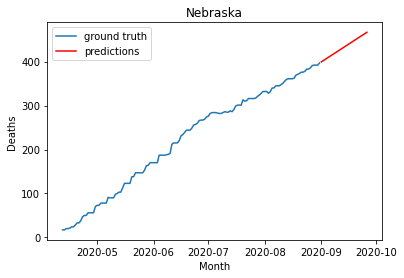

State: Nevada
	Top 3 Scores For Nevada
	--Score: 0.8824368367998195 ['add', True]
	--Score: 0.8824368367998195 ['add', True]


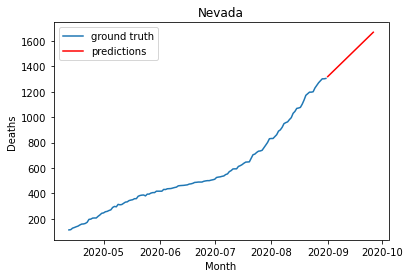

State: New Hampshire
	Top 3 Scores For New Hampshire
	--Score: 0.16544169433126257 ['add', True]
	--Score: 0.16544169433126257 ['add', True]


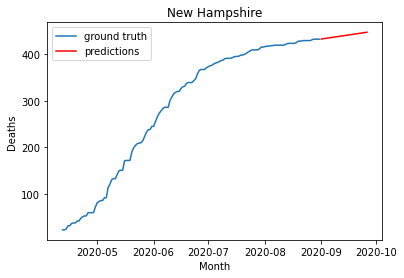

State: New Jersey
	Top 3 Scores For New Jersey
	--Score: 0.11887706228367687 ['add', True]
	--Score: 0.11887706228367687 ['add', True]


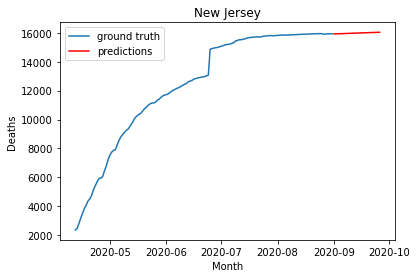

State: New Mexico
	Top 3 Scores For New Mexico
	--Score: 0.26785986768417525 ['add', True]
	--Score: 0.26785986768417525 ['add', True]


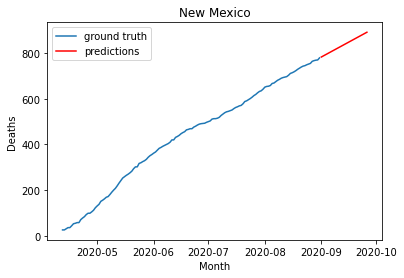

State: New York
	Top 3 Scores For New York
	--Score: 0.11746308391288923 ['add', True]
	--Score: 0.11746308391288923 ['add', True]


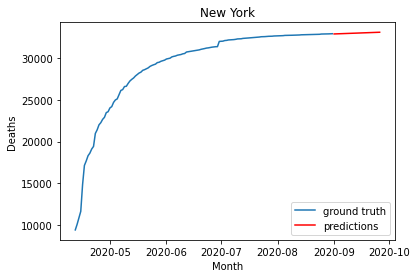

State: North Carolina
	Top 3 Scores For North Carolina
	--Score: 0.47076503110136736 ['add', True]
	--Score: 0.47076503110136736 ['add', True]


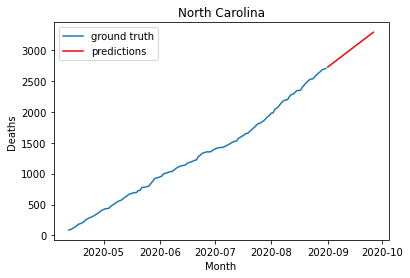

State: North Dakota
	Top 3 Scores For North Dakota
	--Score: 0.6931500337896924 ['add', True]
	--Score: 0.6931500337896924 ['add', True]


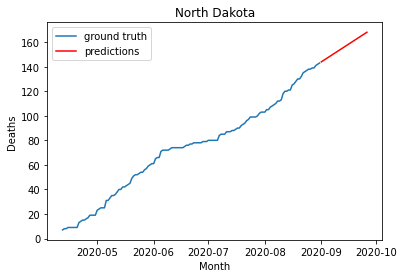

State: Ohio
	Top 3 Scores For Ohio
	--Score: 0.6307151625475582 ['add', True]
	--Score: 0.6307151625475582 ['add', True]


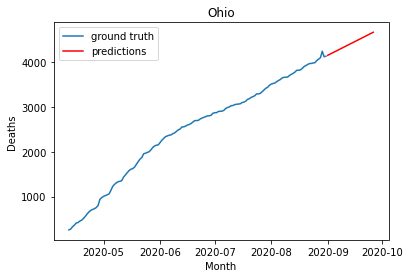

State: Oklahoma
	Top 3 Scores For Oklahoma
	--Score: 0.6862601116685277 ['add', True]
	--Score: 0.6862601116685277 ['add', True]


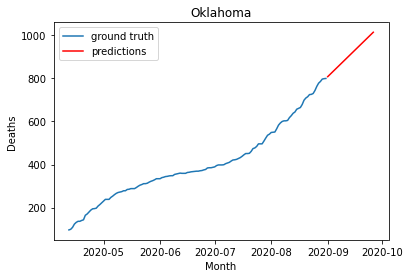

State: Oregon
	Top 3 Scores For Oregon
	--Score: 0.7732347216049744 ['add', True]
	--Score: 0.7732347216049744 ['add', True]


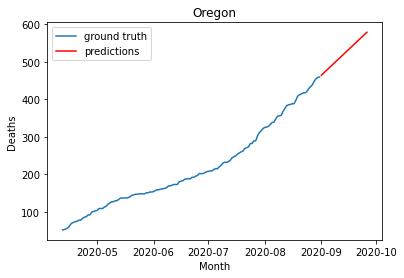

State: Pennsylvania
	Top 3 Scores For Pennsylvania
	--Score: 0.14956384525812763 ['add', True]
	--Score: 0.14956384525812763 ['add', True]


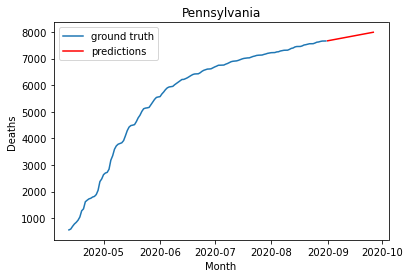

State: Rhode Island
	Top 3 Scores For Rhode Island
	--Score: 0.132981567274076 ['add', True]
	--Score: 0.132981567274076 ['add', True]


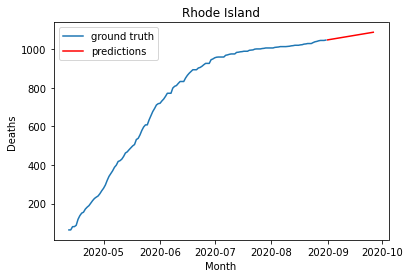

State: South Carolina
	Top 3 Scores For South Carolina
	--Score: 0.7037365824893521 ['add', True]
	--Score: 0.7037365824893521 ['add', True]


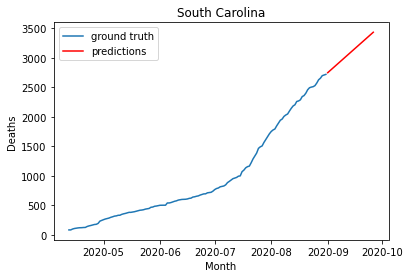

State: South Dakota
	Top 3 Scores For South Dakota
	--Score: 0.4468348716177657 ['add', True]
	--Score: 0.4468348716177657 ['add', True]


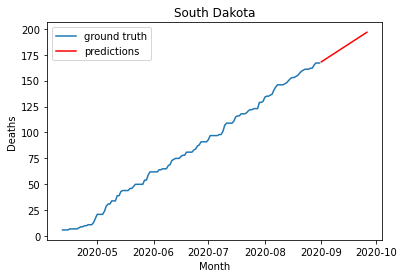

State: Tennessee
	Top 3 Scores For Tennessee
	--Score: 0.5963197255587519 ['add', True]
	--Score: 0.5963197255587519 ['add', True]


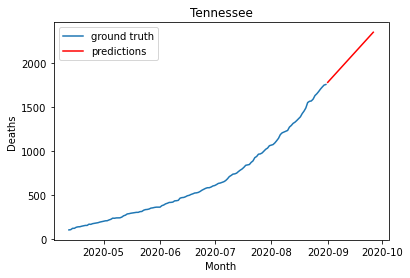

State: Texas
	Top 3 Scores For Texas
	--Score: 0.610853520755404 ['add', True]
	--Score: 0.610853520755404 ['add', True]


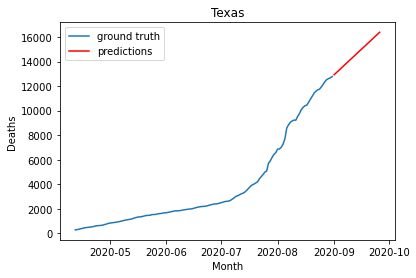

State: Utah
	Top 3 Scores For Utah
	--Score: 0.6597176562600754 ['add', True]
	--Score: 0.6597176562600754 ['add', True]


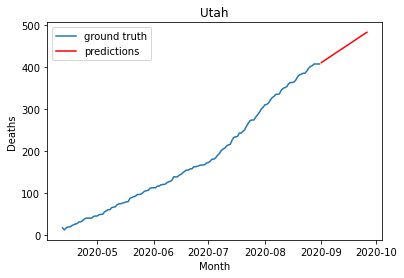

State: Vermont
	Top 3 Scores For Vermont
	--Score: 0.07516777233707227 ['add', True]
	--Score: 0.07516777233707227 ['add', True]


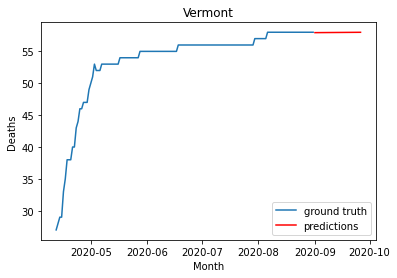

State: Virginia
	Top 3 Scores For Virginia
	--Score: 0.2491919686131376 ['add', True]
	--Score: 0.2491919686131376 ['add', True]


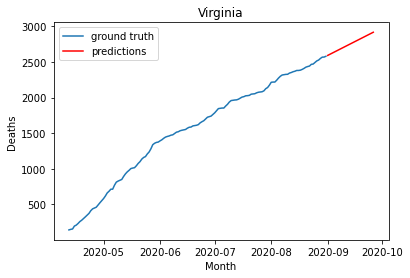

State: Washington
	Top 3 Scores For Washington
	--Score: 0.259327009141144 ['add', True]
	--Score: 0.259327009141144 ['add', True]


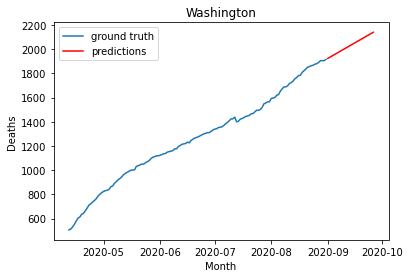

State: West Virginia
	Top 3 Scores For West Virginia
	--Score: 1.57862206917117 ['add', True]
	--Score: 1.57862206917117 ['add', True]


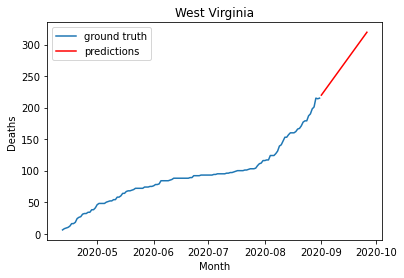

State: Wisconsin
	Top 3 Scores For Wisconsin
	--Score: 0.441072975069944 ['add', True]
	--Score: 0.441072975069944 ['add', True]


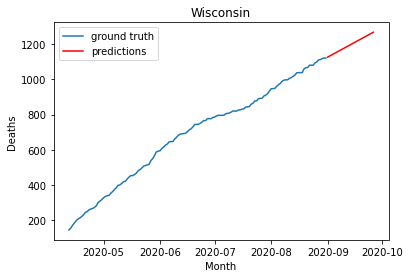

State: Wyoming
	Top 3 Scores For Wyoming
	--Score: 2.2198542075514722 ['add', True]
	--Score: 2.2198542075514722 ['add', True]


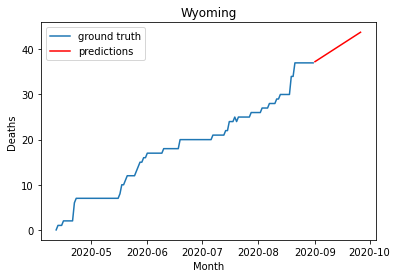

In [15]:
# Get all configs
cfgs = exp_smoothing_configs(None)

# Get train and test dates for plot
train_dates = sorted(list(deaths_df.Date.unique()))
test_dates  = sorted(list(test_df.Date.unique()))

# Average overall MAPE
overall_average_MAPE = 0

# Setup dataframe to store results
deaths_output_df = pd.DataFrame()

# Grid search for each state
for state in state_names:
  scores = grid_search(deaths_df[deaths_df.Province_State == state].Deaths, cfgs, 20, state, parallel=True)
  overall_average_MAPE += scores[0][1]
  predictions = build_best_deaths_model(train_dates, test_dates, deaths_df[deaths_df.Province_State == state].Deaths, state, scores[0][0], len(test_dates))
  deaths_output_df = deaths_output_df.append(predictions)

In [16]:
deaths_output_df

,Province_State,Date,Deaths
0,Alabama,2020-09-01,2202.478182
1,Alabama,2020-09-02,2222.031105
2,Alabama,2020-09-03,2241.584027
3,Alabama,2020-09-04,2261.136949
4,Alabama,2020-09-05,2280.689872
...,...,...,...
21,Wyoming,2020-09-22,42.743017
22,Wyoming,2020-09-23,43.003689
23,Wyoming,2020-09-24,43.264361
24,Wyoming,2020-09-25,43.525033


In [17]:
# Average MAPE across validation dataset
overall_average_MAPE = overall_average_MAPE/50
print("Average MAPE for Deaths: {}%".format(overall_average_MAPE))

deaths_output_df = deaths_output_df.sort_values(by=['Date', 'Province_State'])
deaths_output_df.to_csv('Round_1/ETS_Deaths_Predictions.csv', index=False)

Average MAPE for Deaths: 0.5981679786468024%


# Create Required Submission

In [18]:
confirmed_predictions = pd.read_csv('./Round_1/ETS_Confirmed_Predictions.csv')
confirmed_predictions.head()

,Province_State,Date,Confirmed
0,Alabama,2020-09-01,127360.409428
1,Alaska,2020-09-01,5324.861978
2,Arizona,2020-09-01,202259.297277
3,Arkansas,2020-09-01,61809.189712
4,California,2020-09-01,717976.527574


In [19]:
deaths_predictions = pd.read_csv('./Round_1/ETS_Deaths_Predictions.csv')
deaths_predictions.head()

,Province_State,Date,Deaths
0,Alabama,2020-09-01,2202.478182
1,Alaska,2020-09-01,37.521777
2,Arizona,2020-09-01,5065.522863
3,Arkansas,2020-09-01,810.581846
4,California,2020-09-01,13139.790367


In [20]:
test_df['Confirmed'] = confirmed_predictions['Confirmed']
test_df['Deaths'] = deaths_predictions['Deaths']

In [21]:
test_df[test_df.Province_State == 'Pennsylvania']

,ForecastID,Province_State,Date,Confirmed,Deaths
37,37,Pennsylvania,2020-09-01,139434.434052,7666.747374
87,87,Pennsylvania,2020-09-02,140097.893634,7679.577403
137,137,Pennsylvania,2020-09-03,140761.353217,7692.407432
187,187,Pennsylvania,2020-09-04,141424.812799,7705.237461
237,237,Pennsylvania,2020-09-05,142088.272382,7718.067490
287,287,Pennsylvania,2020-09-06,142751.731964,7730.897519
337,337,Pennsylvania,2020-09-07,143415.191546,7743.727547
387,387,Pennsylvania,2020-09-08,144078.651129,7756.557576
437,437,Pennsylvania,2020-09-09,144742.110711,7769.387605
487,487,Pennsylvania,2020-09-10,145405.570294,7782.217634


In [22]:
test_df.drop(['Province_State','Date'], inplace=True, axis=1)
test_df.head()

,ForecastID,Confirmed,Deaths
0,0,127360.409428,2202.478182
1,1,5324.861978,37.521777
2,2,202259.297277,5065.522863
3,3,61809.189712,810.581846
4,4,717976.527574,13139.790367


In [23]:
test_df.to_csv('Team3_round1.csv', index=False)